In [137]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
data_dir = "krylov_data4"
exact_file = "hubbard_exact_4.hdf5"
l = 4
output_filename = f"hubbard_{l}_error.pdf"
d_max = 30
d_min = 3

if l == 2:
    num_cnot = 22
elif l == 3:
    num_cnot = 191
elif l == 4:
    num_cnot = 472
else:
    raise ValueError(f"Invalid dimension {l}")

In [139]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [140]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (-4.60281914709557+0j).


In [141]:
# subspace_files = [f for f in all_files if "subspace" in f]
# for i in range(len(subspace_files)):
#     f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
#     ref_energy = f_subspace["reference_energy"][()]
#     f_subspace.close()
#     print(f"Reference energy = {ref_energy}")

In [142]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df["num_2q"] = steps * num_cnot
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps  num_2q
i                                                               
0    3  1.000000e-08 -4.588337        3  0.014482     60   28320
1    4  1.000000e-08 -4.600704        4  0.002116     60   28320
2    5  1.000000e-08 -4.601492        5  0.001327     60   28320
3    6  1.000000e-08 -4.602057        6  0.000762     60   28320
4    7  1.000000e-08 -4.602226        7  0.000594     60   28320
..  ..           ...       ...      ...       ...    ...     ...
28  31  1.000000e-08 -4.602793       20  0.000027    200   94400
29  32  1.000000e-08 -4.602794       21  0.000026    200   94400
30  33  1.000000e-08 -4.602795       21  0.000025    200   94400
31  34  1.000000e-08 -4.602795       22  0.000024    200   94400
32  35  1.000000e-08 -4.602796       22  0.000023    200   94400

[363 rows x 7 columns]


In [143]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d           eps    energy  num_pos     error  steps  num_2q
i                                                               
17  20  1.000000e-08 -4.602678       15  0.000141     60   28320
18  21  1.000000e-08 -4.602687       15  0.000133     60   28320
19  22  1.000000e-08 -4.602693       16  0.000126     60   28320
20  23  1.000000e-08 -4.602700       16  0.000120     60   28320
21  24  1.000000e-08 -4.602705       17  0.000114     60   28320
..  ..           ...       ...      ...       ...    ...     ...
28  31  1.000000e-08 -4.602793       20  0.000027    200   94400
29  32  1.000000e-08 -4.602794       21  0.000026    200   94400
30  33  1.000000e-08 -4.602795       21  0.000025    200   94400
31  34  1.000000e-08 -4.602795       22  0.000024    200   94400
32  35  1.000000e-08 -4.602796       22  0.000023    200   94400

[176 rows x 7 columns]


In [144]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d           eps    energy  num_pos     error  steps  num_2q
i                                                             
0  3  1.000000e-08 -4.588337        3  0.014482     60   28320
1  4  1.000000e-08 -4.600704        4  0.002116     60   28320
2  5  1.000000e-08 -4.601492        5  0.001327     60   28320
3  6  1.000000e-08 -4.602057        6  0.000762     60   28320
4  7  1.000000e-08 -4.602226        7  0.000594     60   28320


In [145]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.02544 ha.


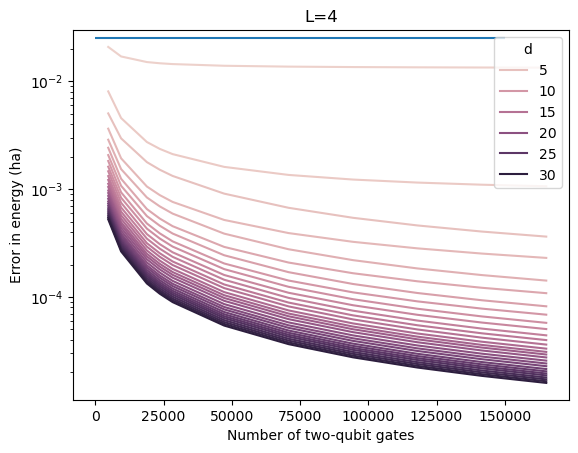

In [150]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 150_000)
sns.lineplot(ax=ax, data=df_small, x="num_2q", y="error", hue="d")
# plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of two-qubit gates")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [147]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [148]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.013424472086107642 0.02089482710680457
4 0.0010641772910195968 0.008080461052326626
5 0.0003632300677063327 0.005049986357144043
6 0.00023041774661258785 0.0036433388571062153
7 0.0001419610530923876 0.00287783688033727
8 0.00010846887197413224 0.0024237503967281526
9 8.194366546643295e-05 0.0020725083489612217
10 6.852062690843042e-05 0.0018273680385547664
11 5.753956654963588e-05 0.0016180562751451077
12 5.038762935694052e-05 0.0014664705253206733
13 4.4068551382281385e-05 0.00132279478991304
14 3.9811869601003025e-05 0.0012186279230368413
15 3.6166470013476726e-05 0.0011239162929079782
16 3.315449876595267e-05 0.0010482385211352252


In [149]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_4348/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.013424472086107642 and 0.02089482710680457